Importy bibliotek

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

Wczytanie danych, przetwarzanie i inżynieria cech

In [12]:
FILE = 'data/stan_ustalony.csv'

# Lista cech (bazowa)
SELECTED_FEATURES = [
    'Active Power 1 (Cycle) [W]',
    'Reactive Power 1 (Cycle) [VAr]',
    'Power Factor 1 (Cycle) (Load)',
    'THD I1 (Cycle) [%]',
    'RMS - non-Fundamental I1 (Cycle) [A]',
    'Phasor Angle I1 (Cycle) [°]',
    'Voltage and Current - Harmonics Amplitude I1 Harmonic 3 (Cycle) [A]',
    'Voltage and Current - Harmonics Amplitude I1 Harmonic 5 (Cycle) [A]',
    'Active Power - per Harmonic 1 Harmonic 3 (Cycle) [W]',
    'RMS I1 (Cycle) [A]'
]

# Lista wszystkich urządzeń/klas
DEVICE_COLUMNS = [
    'coffee_machine', 'electric_kettle', 'fridge', 
    'laptop', 'mixer', 'phone_charger', 'printer', 
    'sandwich_maker', 'tv'
]

# Wczytanie surowych danych
df = pd.read_csv(FILE, sep=';', decimal=',')

# Funkcja czyszcząca wartości Power Factor (usuwanie 'CAP'/'IND')
def clean_power_factor(value):
    if isinstance(value, str):
        value = value.replace(' CAP', '').replace(' IND', '').strip()
        value = value.replace(',', '.')
    return value

# Czyszczenie kolumn Power Factor
PF_COLS = [col for col in SELECTED_FEATURES if 'Power Factor' in col]
for col in PF_COLS:
    df[col] = df[col].apply(clean_power_factor)

# Konwersja cech na typ numeryczny
for col in SELECTED_FEATURES:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# ==============================================================================
# Obliczenia Mocy Deformacji 
# ==============================================================================
# Definicja kolumn pomocniczych
col_v = 'RMS V1N (Cycle) [V]'
col_i = 'RMS I1 (Cycle) [A]'
col_p = 'Active Power 1 (Cycle) [W]'
col_q = 'Reactive Power 1 (Cycle) [VAr]'

# Konwersja napięcia i prądu na float
df[col_v] = pd.to_numeric(df[col_v], errors='coerce')
df[col_i] = pd.to_numeric(df[col_i], errors='coerce')

# Obliczenie całkowitej mocy pozornej (S)
df['S_total_calc'] = df[col_v] * df[col_i]

# Obliczenie mocy deformacji (D) ze wzoru: D = sqrt(S^2 - P^2 - Q^2)
term_under_sqrt = (df['S_total_calc']**2) - (df[col_p]**2) - (df[col_q]**2)
new_feature_name = 'Budeanu Distortion Power [VAr]'
df[new_feature_name] = np.sqrt(np.maximum(term_under_sqrt, 0))

# Aktualizacja listy cech o moc deformacji
if new_feature_name not in SELECTED_FEATURES:
    SELECTED_FEATURES.append(new_feature_name)
    print(f"-> Dodano cechę: {new_feature_name}")
# ==============================================================================

# Weryfikacja liczby wierszy przed czyszczeniem
print(f"Liczba wierszy przed czyszczeniem: {len(df)}")

# Usunięcie wierszy z brakującymi danymi
df.dropna(subset=SELECTED_FEATURES, inplace=True)
print(f"Liczba wierszy po usunięciu NaN: {len(df)}")

if len(df) == 0:
    raise ValueError("Zbiór danych jest pusty! Sprawdź poprawność nazw kolumn.")

# Przygotowanie macierzy cech (X) i etykiet (y)
for col in DEVICE_COLUMNS:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)

X = df[SELECTED_FEATURES].values
y = df[DEVICE_COLUMNS].values

# Podział na zbiory treningowe/testowe i standaryzacja
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("-" * 30)
print(f"Wymiary X_train: {X_train_scaled.shape}, wymiary y_train: {y_train.shape}")
print(f"Liczba cech: {len(SELECTED_FEATURES)}")
print(SELECTED_FEATURES)

-> Dodano cechę: Budeanu Distortion Power [VAr]
Liczba wierszy przed czyszczeniem: 497
Liczba wierszy po usunięciu NaN: 497
------------------------------
Wymiary X_train: (397, 11), wymiary y_train: (397, 9)
Liczba cech: 11
['Active Power 1 (Cycle) [W]', 'Reactive Power 1 (Cycle) [VAr]', 'Power Factor 1 (Cycle) (Load)', 'THD I1 (Cycle) [%]', 'RMS - non-Fundamental I1 (Cycle) [A]', 'Phasor Angle I1 (Cycle) [°]', 'Voltage and Current - Harmonics Amplitude I1 Harmonic 3 (Cycle) [A]', 'Voltage and Current - Harmonics Amplitude I1 Harmonic 5 (Cycle) [A]', 'Active Power - per Harmonic 1 Harmonic 3 (Cycle) [W]', 'RMS I1 (Cycle) [A]', 'Budeanu Distortion Power [VAr]']


Analiza rozkładu klas (urządzeń) w zbiorach treningowych i testowych

In [13]:
# Zliczanie aktywności urządzeń w zbiorach
train_counts = y_train.sum(axis=0)
test_counts = y_test.sum(axis=0)
total_counts = train_counts + test_counts

# Utworzenie ramki danych z podsumowaniem
distribution_df = pd.DataFrame({
    'Device': DEVICE_COLUMNS,
    'Train (1s)': train_counts,
    'Test (1s)': test_counts,
    'Total (1s)': total_counts,
    'Share [%]': (total_counts / len(df) * 100).round(2)
})

# Sortowanie malejąco wg liczby wystąpień
distribution_df.sort_values(by='Total (1s)', ascending=False, inplace=True)

print("Szczegółowy rozkład aktywności urządzeń:")
try:
    display(distribution_df)
except NameError:
    print(distribution_df)

# Weryfikacja występowania pustych klas
zero_classes = distribution_df[distribution_df['Total (1s)'] == 0]['Device'].tolist()
if zero_classes:
    print(f"\nUWAGA: Brak próbek pozytywnych dla: {zero_classes}")
else:
    print("\nWszystkie urządzenia posiadają reprezentację w danych.")

Szczegółowy rozkład aktywności urządzeń:


,Device,Train (1s),Test (1s),Total (1s),Share [%]
2,fridge,312,80,392,78.87
8,tv,231,50,281,56.54
0,coffee_machine,69,11,80,16.10
3,laptop,65,12,77,15.49
5,phone_charger,37,5,42,8.45
7,sandwich_maker,20,7,27,5.43
1,electric_kettle,21,5,26,5.23
6,printer,17,4,21,4.23
4,mixer,5,1,6,1.21



Wszystkie urządzenia posiadają reprezentację w danych.


Random Forest

In [9]:
# Konfiguracja modelu
#rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

rf_model = RandomForestClassifier(
    n_estimators=320,        # większa liczba drzew
    max_depth=25,            # zmniejszona glebokosc
    min_samples_split=5,     # wezel musi miec min 5 probek do podzialu
    min_samples_leaf=2,      # lisc min 2 probki
    class_weight='balanced', # wieksze wagi dla mniejszościowych klas
    n_jobs=-1,               # Użycie wszystkich rdzeni CPU
    random_state=42
)

# Dopasowanie modelu do danych treningowych
print("Rozpoczynam trening Random Forest...")
rf_model.fit(X_train_scaled, y_train)
print("Trening zakończony.")

# Predykcja na zbiorze testowym
y_pred = rf_model.predict(X_test_scaled)

# Obliczenie dokładności (Exact Match Ratio)
acc = accuracy_score(y_test, y_pred)
print(f"\nDokładność całkowita (Exact Match): {acc:.2%}\n")

# Generowanie raportu klasyfikacji
print("Raport klasyfikacji:")
print(classification_report(y_test, y_pred, target_names=DEVICE_COLUMNS, zero_division=0))

Rozpoczynam trening Random Forest...
Trening zakończony.

Dokładność całkowita (Exact Match): 76.00%

Raport klasyfikacji:
                 precision    recall  f1-score   support

 coffee_machine       0.92      1.00      0.96        11
electric_kettle       1.00      1.00      1.00         5
         fridge       0.91      0.94      0.93        80
         laptop       0.60      0.75      0.67        12
          mixer       1.00      1.00      1.00         1
  phone_charger       0.80      0.80      0.80         5
        printer       1.00      0.50      0.67         4
 sandwich_maker       0.86      0.86      0.86         7
             tv       0.96      0.88      0.92        50

      micro avg       0.90      0.90      0.90       175
      macro avg       0.89      0.86      0.87       175
   weighted avg       0.90      0.90      0.90       175
    samples avg       0.91      0.91      0.90       175



Deep Neural Network (PyTorch)

TensorFlow version: 2.10.0
Dostępne urządzenia: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 64)                768       
                                                                 
 dropout_14 (Dropout)        (None, 64)                0         
                                                                 
 dense_21 (Dense)            (None, 32)                2080      
                                                                 
 dropout_15 (Dropout)        (None, 32)                0         
                                                                 
 dense_22 (Dense)            (None, 9)                 297       
                                                                 
Total params: 3,145
Trainable params: 3,145
Non-trainable params: 0
___

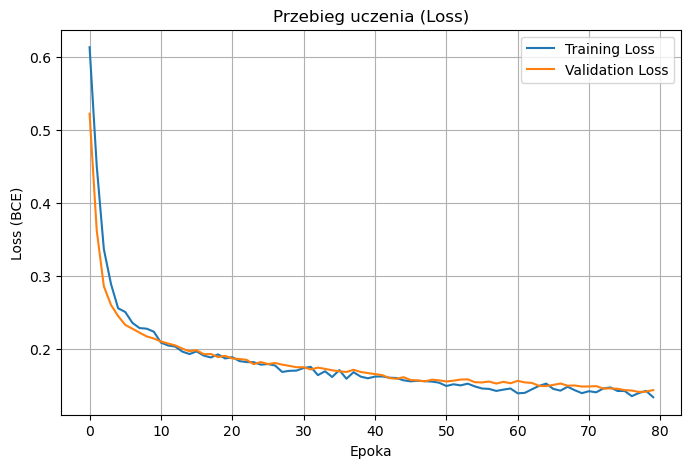

4/4 [==============================] - 0s 2ms/step

Dokładność DNN (Exact Match): 71.00%
Szczegółowy raport klasyfikacji:
                 precision    recall  f1-score   support

 coffee_machine       1.00      1.00      1.00        11
electric_kettle       1.00      1.00      1.00         5
         fridge       0.90      0.96      0.93        80
         laptop       0.50      0.25      0.33        12
          mixer       0.00      0.00      0.00         1
  phone_charger       0.00      0.00      0.00         5
        printer       1.00      0.75      0.86         4
 sandwich_maker       0.80      0.57      0.67         7
             tv       0.94      0.88      0.91        50

      micro avg       0.90      0.84      0.87       175
      macro avg       0.68      0.60      0.63       175
   weighted avg       0.86      0.84      0.84       175
    samples avg       0.92      0.88      0.88       175



In [20]:
# Sprawdzenie dostępności GPU
print(f"TensorFlow version: {tf.__version__}")
print(f"Dostępne urządzenia: {tf.config.list_physical_devices()}")

input_dim = X_train_scaled.shape[1]
output_dim = y_train.shape[1]  # Liczba urządzeń (klas)

model = models.Sequential([
    # Warstwa wejściowa -> Ukryta 1
    layers.Dense(64, activation='relu', input_shape=(input_dim,)),
    layers.Dropout(0.3),  # Zapobiega overfittingowi
    
    # Ukryta 1 -> Ukryta 2
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    
    # Warstwa wyjściowa
    layers.Dense(output_dim)
])

# Wyświetlenie podsumowania architektury
model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    # from_logits=True to odpowiednik BCEWithLogitsLoss
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

EPOCHS = 60
BATCH_SIZE = 32

print("Rozpoczynam trening sieci neuronowej (TensorFlow)...")

history = model.fit(
    X_train_scaled, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    verbose=1
)

# Wykres funkcji straty
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Przebieg uczenia (Loss)')
plt.xlabel('Epoka')
plt.ylabel('Loss (BCE)')
plt.legend()
plt.grid(True)
plt.show()

# Predykcja zwraca "logits" (surowe wartości)
logits = model.predict(X_test_scaled)

# Konwersja logits -> prawdopodobieństwa (Sigmoid)
probs = tf.nn.sigmoid(logits).numpy()

# Binaryzacja wyników (Próg 0.5)
y_pred_numpy = (probs > 0.5).astype(int)

# Raport wyników
from sklearn.metrics import accuracy_score, classification_report
acc_dnn = accuracy_score(y_test, y_pred_numpy)

print(f"\nDokładność DNN (Exact Match): {acc_dnn:.2%}")
print("Szczegółowy raport klasyfikacji:")
print(classification_report(y_test, y_pred_numpy, target_names=DEVICE_COLUMNS, zero_division=0))